**Задача**

Вам предстоит научитсья моделировать отток клиентов телеком компании. Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаться удержать его, предложив какие-то бонусы.

# Первая часть. Исследование

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [4]:
data = pd.read_csv('./train.csv', na_values = [' '])
test = pd.read_csv('./test.csv', na_values = [' '])

In [7]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [8]:
data.TotalSpent.dtype

dtype('float64')

In [9]:
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
970,14,19.35,324.80,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
4917,29,58.00,1734.50,Female,0,No,No,Yes,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Credit card (automatic),0
3467,1,70.45,70.45,Male,0,No,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
535,64,89.45,5692.65,Male,0,Yes,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,No,No,One year,No,Bank transfer (automatic),0
5250,72,84.10,5981.65,Male,1,Yes,No,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),0


In [10]:
data.isnull().mean()
# есть пропущенные значения в столбце TotalSpent

ClientPeriod                0.000000
MonthlySpending             0.000000
TotalSpent                  0.001704
Sex                         0.000000
IsSeniorCitizen             0.000000
HasPartner                  0.000000
HasChild                    0.000000
HasPhoneService             0.000000
HasMultiplePhoneNumbers     0.000000
HasInternetService          0.000000
HasOnlineSecurityService    0.000000
HasOnlineBackup             0.000000
HasDeviceProtection         0.000000
HasTechSupportAccess        0.000000
HasOnlineTV                 0.000000
HasMovieSubscription        0.000000
HasContractPhone            0.000000
IsBillingPaperless          0.000000
PaymentMethod               0.000000
Churn                       0.000000
dtype: float64

In [11]:
# создадим более подробную таблицу, которая описывает кол-во уникальных и нулевых значений в столбцах, а также Типы и примеры данных.

list_ = []
for name in data.columns:
  n_unique = len(data[name].unique())
  n_null = data[name].isnull().sum()
  type_of_data = data[name].dtype.name
  list_.append([name, n_unique, n_null, type_of_data, data[name].unique()[:min(n_unique, 5)]])

pd.DataFrame(list_, columns = ['column', 'n_unique', ' n_null', 'data_type', 'values'] )

# вывод: всего три количественных признака: ClientPeriod, MonthlySpending, TotalSpent, остальные являются категориальными, то есть изначальная разбивка признаков корректна

,column,n_unique,n_null,data_type,values
0,ClientPeriod,73,0,int64,"[55, 72, 1, 32, 60]"
1,MonthlySpending,1468,0,float64,"[19.5, 25.85, 75.9, 79.3, 115.25]"
2,TotalSpent,4978,9,float64,"[1026.35, 1872.2, 75.9, 2570.0, 6758.45]"
3,Sex,2,0,object,"[Male, Female]"
4,IsSeniorCitizen,2,0,int64,"[0, 1]"
5,HasPartner,2,0,object,"[Yes, No]"
6,HasChild,2,0,object,"[Yes, No]"
7,HasPhoneService,2,0,object,"[Yes, No]"
8,HasMultiplePhoneNumbers,3,0,object,"[No, Yes, No phone service]"
9,HasInternetService,3,0,object,"[No, Fiber optic, DSL]"


In [12]:
# посмотрим, что за строки, в которых TotalSpent = NaN
data[data['TotalSpent'].isnull()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [13]:
# Судя по всему TotalSpent должен быть 0, т.к. это клиенты, которые еще не пользуются услугами, т.к. ClientPeriod = 0.
data[data['ClientPeriod'] == 0]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [14]:
# заменим пропуски в столбце TotalSpent на 0
data['TotalSpent'] = data['TotalSpent'].fillna(0)
data[num_cols].isnull().sum()

ClientPeriod       0
MonthlySpending    0
TotalSpent         0
dtype: int64

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

In [5]:
import seaborn as sns

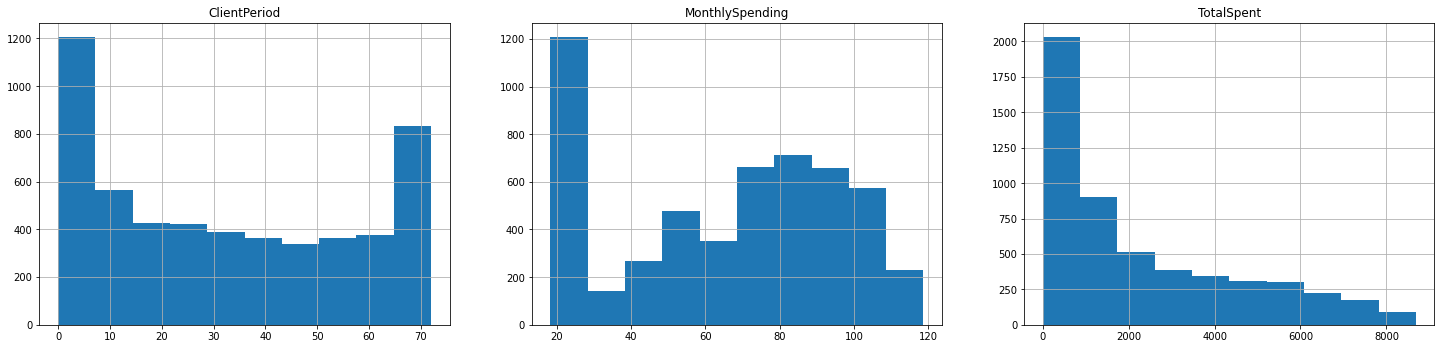

In [15]:
# Визуализация распределения количественных признаков (гистограммы)
fig = plt.figure(figsize=(25, 15))
for i, column in enumerate(data[num_cols]):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.set_title(column)
    data[column].hist()
plt.subplots_adjust(hspace=0.7, wspace=0.2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


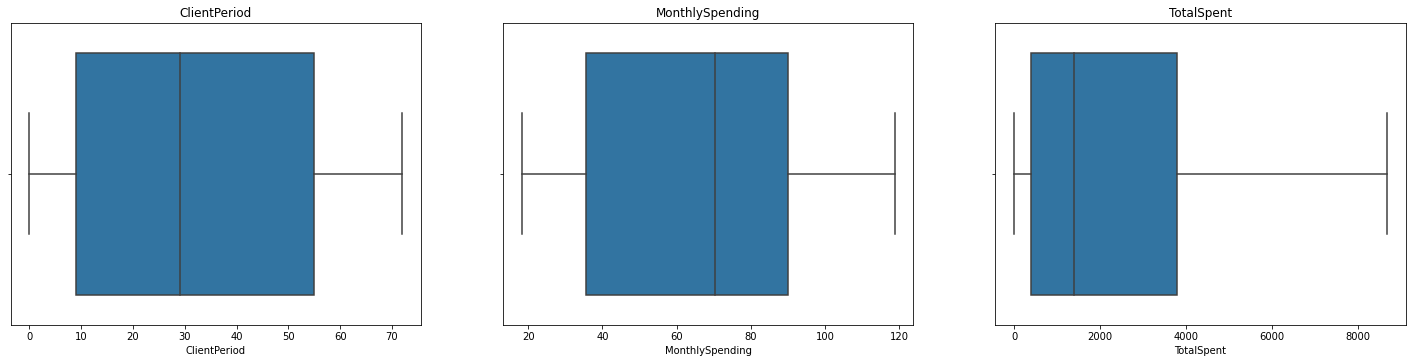

In [16]:
# Визуализация распределения количественных признаков (боксплоты)
fig = plt.figure(figsize=(25, 15))
for i, column in enumerate(data[num_cols]):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.set_title(column)
    sns.boxplot(data[column]);
plt.subplots_adjust(hspace=0.7, wspace=0.2)

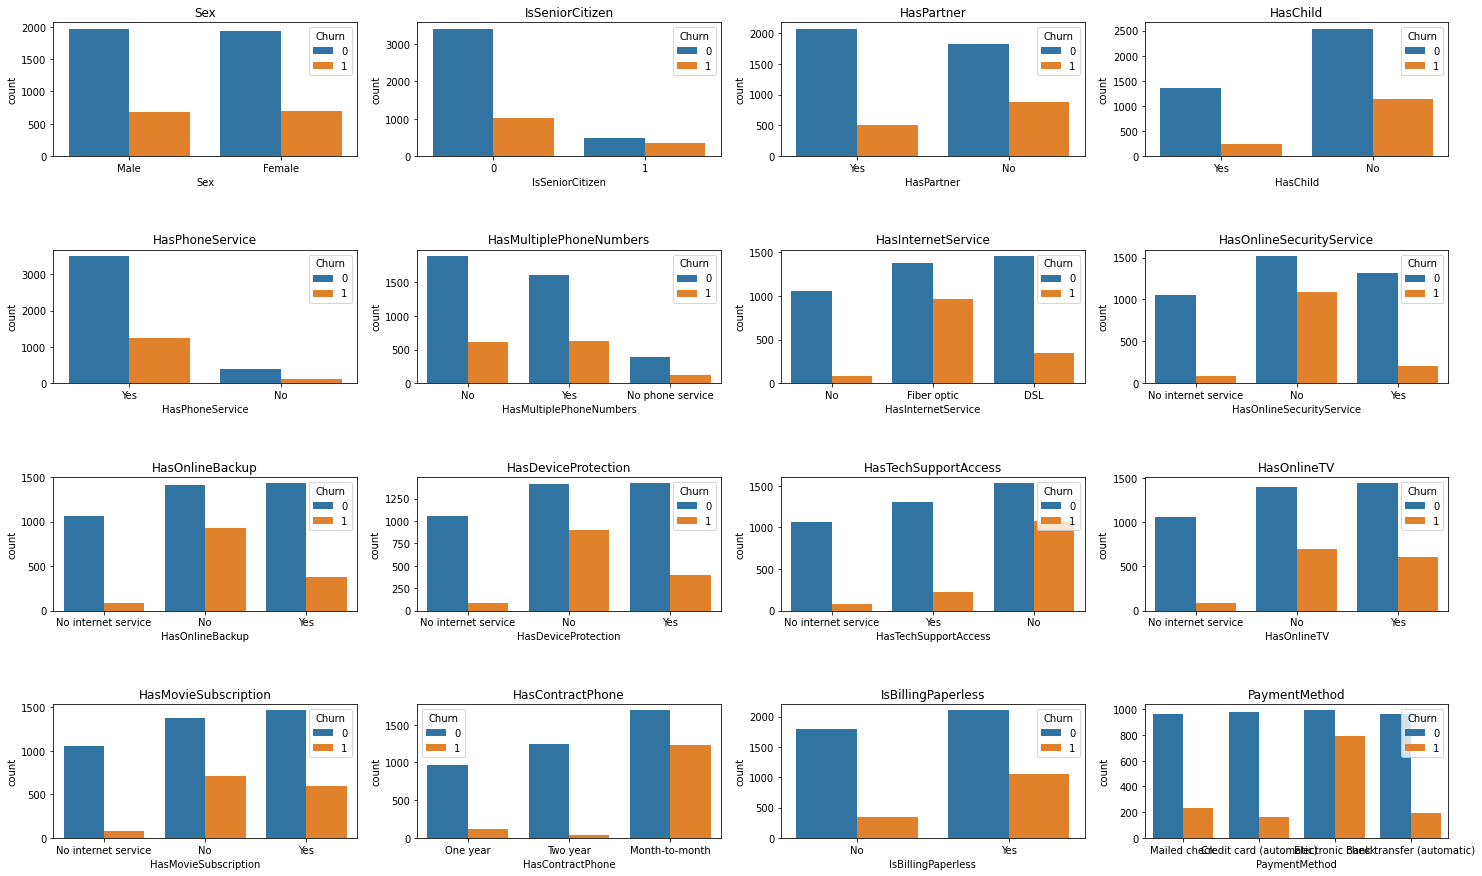

In [25]:
# Визуализация распределения кат. признаков отнтсительно целевого

fig = plt.figure(figsize=(25, 15))
for i, column in enumerate(data[cat_cols]):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.set_title(cat_cols[i])
    sns.countplot(x=cat_cols[i], data=data, ax=ax, hue = target_col)
plt.subplots_adjust(hspace=0.7, wspace=0.2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


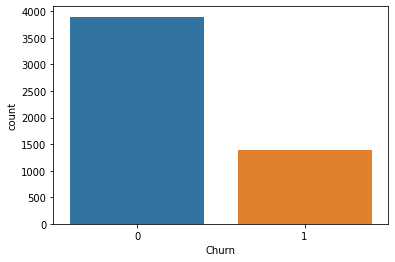

In [ ]:
# классы являются несбалансированными, клиентов с классом  0 больше, чем клиентов с классом 1
sns.countplot(data[target_col]);

In [ ]:
# соотношение классов: 0 - 74%, 1 - 26%
data[target_col].value_counts(normalize=True)

0    0.737978
1    0.262022
Name: Churn, dtype: float64

Выводы из графиков:
1. количественные признаки имеют распределение, отличное от нормального
2. явных выбросов в данных не обнаружено
3. из клиентов примерно одинаковое кол-во мужчин и женщин; подавлящее большинство пользуется услугами связи и интернетом (HasPhoneService, HasInternetService ), остальные услуги пользуются спросом примерно 50/50
4. в соответсвии с распределением целевой переменной классы  являются несбалансированными (класс 0 - 74%, класс 1 - 26%)

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [30]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [31]:
# кодируем категориальные переменные с помощью one-hot-encoding
dummy = pd.get_dummies(data[cat_cols])

In [32]:
dummy.head()

,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,HasMultiplePhoneNumbers_No,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,0,1,1,...,0,0,1,0,1,0,0,0,0,1
1,0,0,1,0,1,1,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
2,0,0,1,1,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
3,1,1,0,0,1,1,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1
4,0,1,0,0,1,0,1,0,1,0,...,1,0,0,1,1,0,0,1,0,0


In [33]:
X = pd.concat([data[num_cols], dummy], axis = 1)
X.head()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,55,19.50,1026.35,0,0,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
1,72,25.85,1872.20,0,0,1,0,1,1,0,...,0,0,0,1,1,0,0,1,0,0
2,1,75.90,75.90,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
3,32,79.30,2570.00,1,1,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
4,60,115.25,6758.45,0,1,0,0,1,0,1,...,1,0,0,1,1,0,0,1,0,0


In [34]:
y = data[target_col]


In [35]:
# создаем pipeline и производим стратифицированную кросс-валидацию (тк классы несбалансированные) для поиска наилучшего параметра регуляризации
pipe_logit = make_pipeline(StandardScaler(), 
                           LogisticRegression(n_jobs= -1, random_state= 17))
param_grid_logit = {'logisticregression__C' : [100, 10, 1, 0.1, 0.01, 0.001]}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

logit_grid = GridSearchCV(pipe_logit, param_grid_logit, scoring = 'roc_auc', n_jobs = -1, cv = skf)

In [36]:
logit_grid.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=17))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [100, 10, 1, 0.1, 0.01,
                                                   0.001]},
             scoring='roc_auc')

In [37]:
logit_grid.best_params_, logit_grid.best_score_

({'logisticregression__C': 10}, 0.8446105140606793)

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

Логистическая регрессия показала качество 0.844 с параметом С = 10

**Второй способ применения линейных моделей**

In [38]:
bin_cols = data.nunique()[(data.nunique() == 2)].index.to_list()
bin_cols.remove('Churn')
bin_cols 

['Sex',
 'IsSeniorCitizen',
 'HasPartner',
 'HasChild',
 'HasPhoneService',
 'IsBillingPaperless']

In [39]:
from sklearn.preprocessing import LabelEncoder

In [40]:
data[bin_cols] = data[bin_cols].apply(LabelEncoder().fit_transform)
data[bin_cols]

,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,IsBillingPaperless
0,1,0,1,1,1,0
1,1,0,1,0,1,0
2,1,0,0,0,1,1
3,0,1,1,0,1,0
4,0,0,1,1,1,0
...,...,...,...,...,...,...
5277,1,0,0,0,0,0
5278,1,0,1,0,0,1
5279,1,0,0,0,1,0
5280,0,0,0,0,1,1


In [41]:
X = pd.concat((data[bin_cols + num_cols], pd.get_dummies(data[cat_cols])), axis=1)

In [42]:
X.head()

,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,IsBillingPaperless,ClientPeriod,MonthlySpending,TotalSpent,Sex,...,HasMovieSubscription_No,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,1,1,0,55,19.50,1026.35,1,...,0,1,0,0,1,0,0,0,0,1
1,1,0,1,0,1,0,72,25.85,1872.20,1,...,0,1,0,0,0,1,0,1,0,0
2,1,0,0,0,1,1,1,75.90,75.90,1,...,1,0,0,1,0,0,0,0,1,0
3,0,1,1,0,1,0,32,79.30,2570.00,0,...,1,0,0,1,0,0,0,0,0,1
4,0,0,1,1,1,0,60,115.25,6758.45,0,...,0,0,1,0,0,1,0,1,0,0


In [44]:
# корреляции между признаками нет
X.corrwith(data['Churn']).sort_values(ascending=False)

HasContractPhone_Month-to-month                 0.403429
HasOnlineSecurityService_No                     0.352716
HasTechSupportAccess_No                         0.337312
HasInternetService_Fiber optic                  0.300399
PaymentMethod_Electronic check                  0.296715
HasOnlineBackup_No                              0.272217
HasDeviceProtection_No                          0.254124
IsBillingPaperless                              0.194040
IsBillingPaperless                              0.194040
MonthlySpending                                 0.184769
IsSeniorCitizen                                 0.156872
IsSeniorCitizen                                 0.156872
HasMovieSubscription_No                         0.140742
HasOnlineTV_No                                  0.131984
HasOnlineTV_Yes                                 0.059193
HasMovieSubscription_Yes                        0.050521
HasMultiplePhoneNumbers_Yes                     0.039572
HasPhoneService                

In [45]:
X_train, X_val, y_train, y_val= train_test_split(X, data['Churn'], test_size=0.25, random_state=777)

In [46]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])

In [47]:
Cs = np.logspace(-3, 2, 30)

In [48]:
logcv = LogisticRegressionCV(Cs=Cs, random_state=777, scoring='roc_auc')

In [49]:
logcv.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-03, 1.48735211e-03, 2.21221629e-03, 3.29034456e-03,
       4.89390092e-03, 7.27895384e-03, 1.08263673e-02, 1.61026203e-02,
       2.39502662e-02, 3.56224789e-02, 5.29831691e-02, 7.88046282e-02,
       1.17210230e-01, 1.74332882e-01, 2.59294380e-01, 3.85662042e-01,
       5.73615251e-01, 8.53167852e-01, 1.26896100e+00, 1.88739182e+00,
       2.80721620e+00, 4.17531894e+00, 6.21016942e+00, 9.23670857e+00,
       1.37382380e+01, 2.04335972e+01, 3.03919538e+01, 4.52035366e+01,
       6.72335754e+01, 1.00000000e+02]),
                     random_state=777, scoring='roc_auc')

In [50]:
best_C = logcv.C_[0]

In [51]:
logcv.scores_

{1: array([[0.82950405, 0.83119404, 0.83270268, 0.83366721, 0.83487082,
         0.83580238, 0.83663501, 0.83777267, 0.83853935, 0.83931427,
         0.84013042, 0.84090534, 0.84168851, 0.84225734, 0.84274373,
         0.84312295, 0.84346095, 0.84371651, 0.84394734, 0.844071  ,
         0.8442029 , 0.84426885, 0.84438426, 0.84435953, 0.84426885,
         0.84425236, 0.84425236, 0.84435129, 0.84435129, 0.84435129],
        [0.81395175, 0.81535173, 0.81648663, 0.81813513, 0.81915405,
         0.82053746, 0.82184632, 0.82340369, 0.82491965, 0.82623679,
         0.82723086, 0.82810895, 0.8288048 , 0.82942609, 0.83026277,
         0.83056099, 0.8310166 , 0.83131482, 0.8314308 , 0.83155505,
         0.83162133, 0.83174558, 0.8316876 , 0.83170417, 0.831787  ,
         0.83176215, 0.83176215, 0.83176215, 0.83177044, 0.83177044],
        [0.84348802, 0.84420872, 0.8448383 , 0.84549273, 0.8461223 ,
         0.84723235, 0.84748915, 0.84784536, 0.84852464, 0.84883114,
         0.84893883, 0.849021

In [52]:
logcv.scores_[1].mean(axis=0)

array([0.83138626, 0.83235009, 0.83329409, 0.83406185, 0.83495001,
       0.83578748, 0.8363598 , 0.83700978, 0.83759587, 0.83813532,
       0.83847618, 0.83893278, 0.83921405, 0.83946723, 0.83969229,
       0.8397137 , 0.83988078, 0.83994861, 0.84000965, 0.84003933,
       0.84002762, 0.84007722, 0.84002574, 0.83997272, 0.8399529 ,
       0.83990156, 0.839938  , 0.83995945, 0.83996442, 0.83993791])

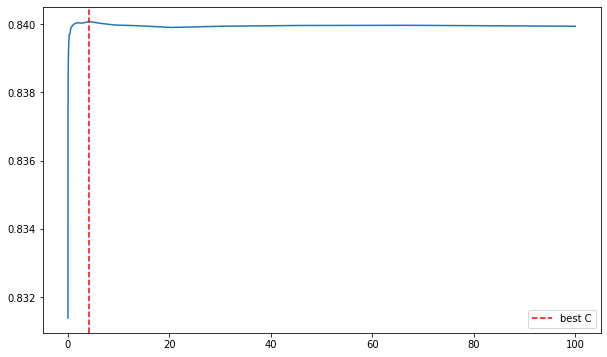

In [53]:
plt.figure(figsize=(10, 6))
sns.lineplot(y=logcv.scores_[1].mean(axis=0), x=logcv.Cs_)
plt.axvline(logcv.C_, ls='--', color='r', label='best C')
plt.legend()

In [54]:
y_train_predicted = logcv.predict_proba(X_train)[:, 1]
y_test_predicted = logcv.predict_proba(X_val)[:, 1]

In [55]:
roc_auc_score(y_val, logcv.predict_proba(X_val)[:, 1])

0.8589161741251525

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [56]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [57]:
import catboost

In [58]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_cols], data[target_col], test_size= 0.3, random_state = 17)

In [59]:
# используем catboost без настройки параметров
boosting_model = catboost.CatBoostClassifier(cat_features= cat_cols, random_seed= 17)
boosting_model.fit(X_train, y_train)

Learning rate set to 0.018006
0:	learn: 0.6804965	total: 79.8ms	remaining: 1m 19s
1:	learn: 0.6696823	total: 105ms	remaining: 52.6s
2:	learn: 0.6593132	total: 126ms	remaining: 41.8s
3:	learn: 0.6482777	total: 144ms	remaining: 35.8s
4:	learn: 0.6382033	total: 173ms	remaining: 34.5s
5:	learn: 0.6299836	total: 198ms	remaining: 32.9s
6:	learn: 0.6214410	total: 243ms	remaining: 34.5s
7:	learn: 0.6131367	total: 278ms	remaining: 34.4s
8:	learn: 0.6041501	total: 288ms	remaining: 31.7s
9:	learn: 0.5959020	total: 303ms	remaining: 30s
10:	learn: 0.5880356	total: 317ms	remaining: 28.5s
11:	learn: 0.5809362	total: 331ms	remaining: 27.3s
12:	learn: 0.5738691	total: 345ms	remaining: 26.2s
13:	learn: 0.5671645	total: 356ms	remaining: 25.1s
14:	learn: 0.5618943	total: 362ms	remaining: 23.8s
15:	learn: 0.5559648	total: 375ms	remaining: 23s
16:	learn: 0.5508244	total: 388ms	remaining: 22.4s
17:	learn: 0.5452460	total: 405ms	remaining: 22.1s
18:	learn: 0.5400126	total: 417ms	remaining: 21.5s
19:	learn: 0.

In [60]:
y_train_predicted = boosting_model.predict_proba(X_train)[:,1]
train_auc = roc_auc_score(y_train, y_train_predicted)
train_auc 

0.896920772106232

In [61]:
y_test_predicted = boosting_model.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test, y_test_predicted)
test_auc 

0.8444205262769188

In [62]:
# Используем catboost с поиском параметров
n_trees = np.linspace(100, 500, 5)
learn_rate = [0.01, 0.02, 0.03, 0.04, 0.05]

In [63]:
results = []
for n, l in np.array([(i,j) for i in n_trees for j in learn_rate]):
  boost_model_tuned = catboost.CatBoostClassifier(iterations= n, learning_rate= l, cat_features= cat_cols, random_seed= 17)
  boost_model_tuned.fit(X_train, y_train)
  auc = roc_auc_score(y_test, boost_model_tuned.predict_proba(X_test)[:,1])
  results.append([n, l, auc])


Выходные данные были обрезаны до нескольких последних строк (5000).
100:	learn: 0.3922965	total: 1.3s	remaining: 2.56s
101:	learn: 0.3918547	total: 1.31s	remaining: 2.55s
102:	learn: 0.3917035	total: 1.33s	remaining: 2.54s
103:	learn: 0.3913025	total: 1.34s	remaining: 2.53s
104:	learn: 0.3912089	total: 1.35s	remaining: 2.52s
105:	learn: 0.3911924	total: 1.36s	remaining: 2.49s
106:	learn: 0.3911266	total: 1.36s	remaining: 2.46s
107:	learn: 0.3908620	total: 1.38s	remaining: 2.46s
108:	learn: 0.3904511	total: 1.4s	remaining: 2.45s
109:	learn: 0.3897188	total: 1.41s	remaining: 2.44s
110:	learn: 0.3895182	total: 1.42s	remaining: 2.42s
111:	learn: 0.3894958	total: 1.43s	remaining: 2.4s
112:	learn: 0.3893265	total: 1.44s	remaining: 2.39s
113:	learn: 0.3889528	total: 1.46s	remaining: 2.38s
114:	learn: 0.3888257	total: 1.47s	remaining: 2.36s
115:	learn: 0.3887925	total: 1.48s	remaining: 2.34s
116:	learn: 0.3886163	total: 1.49s	remaining: 2.33s
117:	learn: 0.3886163	total: 1.5s	remaining: 2.31s


In [64]:
res = pd.DataFrame(results, columns= ['trees', 'learn_rate', 'score'])
res[res['score'] == res['score'].max()]

,trees,learn_rate,score
8,200.0,0.04,0.845553


In [65]:
# отдельно обучаем модель, чтобы ее дальше использовать в предскзааниях
boost_model_tuned = catboost.CatBoostClassifier(iterations= 200, learning_rate= 0.04, cat_features= cat_cols, random_seed= 17)
boost_model_tuned.fit(X_train, y_train)

0:	learn: 0.6656005	total: 14.7ms	remaining: 2.94s
1:	learn: 0.6435196	total: 26.8ms	remaining: 2.65s
2:	learn: 0.6236114	total: 35.4ms	remaining: 2.32s
3:	learn: 0.6034924	total: 48.6ms	remaining: 2.38s
4:	learn: 0.5864223	total: 61.2ms	remaining: 2.39s
5:	learn: 0.5733879	total: 73.7ms	remaining: 2.38s
6:	learn: 0.5605027	total: 91ms	remaining: 2.51s
7:	learn: 0.5486998	total: 113ms	remaining: 2.72s
8:	learn: 0.5366364	total: 123ms	remaining: 2.62s
9:	learn: 0.5270925	total: 139ms	remaining: 2.65s
10:	learn: 0.5177763	total: 153ms	remaining: 2.64s
11:	learn: 0.5106846	total: 162ms	remaining: 2.54s
12:	learn: 0.5038323	total: 171ms	remaining: 2.46s
13:	learn: 0.4978745	total: 180ms	remaining: 2.39s
14:	learn: 0.4909265	total: 194ms	remaining: 2.39s
15:	learn: 0.4844390	total: 207ms	remaining: 2.38s
16:	learn: 0.4801851	total: 218ms	remaining: 2.35s
17:	learn: 0.4749425	total: 232ms	remaining: 2.35s
18:	learn: 0.4707774	total: 242ms	remaining: 2.31s
19:	learn: 0.4659056	total: 256ms	re

In [66]:
# Используем grid_search для поиска параметров
boosting_model_1 = catboost.CatBoostClassifier(cat_features= cat_cols, random_seed= 17, silent=True)
boosting_model_1.grid_search({'iterations': np.linspace(100, 500, 5) , 'learning_rate' : np.linspace(0,1,10)[1:]}, 
                           X_train, 
                           y_train,refit=True)


bestTest = 0.4188564729
bestIteration = 88

0:	loss: 0.4188565	best: 0.4188565 (0)	total: 630ms	remaining: 27.7s

bestTest = 0.4249489132
bestIteration = 15

1:	loss: 0.4249489	best: 0.4188565 (0)	total: 1.32s	remaining: 28.4s

bestTest = 0.4222351894
bestIteration = 15

2:	loss: 0.4222352	best: 0.4188565 (0)	total: 2.01s	remaining: 28.2s

bestTest = 0.4268150091
bestIteration = 14

3:	loss: 0.4268150	best: 0.4188565 (0)	total: 2.65s	remaining: 27.2s

bestTest = 0.4307142554
bestIteration = 10

4:	loss: 0.4307143	best: 0.4188565 (0)	total: 3.31s	remaining: 26.5s

bestTest = 0.433559276
bestIteration = 11

5:	loss: 0.4335593	best: 0.4188565 (0)	total: 4.73s	remaining: 30.7s

bestTest = 0.445412177
bestIteration = 9

6:	loss: 0.4454122	best: 0.4188565 (0)	total: 5.38s	remaining: 29.2s

bestTest = 0.4619812378
bestIteration = 6

7:	loss: 0.4619812	best: 0.4188565 (0)	total: 6.03s	remaining: 27.9s

bestTest = 0.4588815906
bestIteration = 5

8:	loss: 0.4588816	best: 0.4188565 (0)	total: 6.

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
             

In [67]:
auc = roc_auc_score(y_test, boosting_model_1.predict_proba(X_test)[:,1])
auc

0.8417433085849085

Лучшее качество 0.845553 с параметрами:
trees = 200	learn_rate = 0.04	

# Предсказания

In [ ]:
best_model = boost_model_tuned

In [ ]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

submission['Churn'] = best_model.predict_proba(X_test)[:,1]
submission.to_csv('./my_submission.csv', index = False)

In [ ]:
submission

,Id,Churn
0,0,0.049638
1,1,0.695835
2,2,0.694553
3,3,0.008459
4,4,0.002462
...,...,...
1756,1756,0.087259
1757,1757,0.004054
1758,1758,0.893322
1759,1759,0.581551


# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.